# Wait


We scrape data from [CA DMV](https://www.dmv.ca.gov/portal/field-office/woodland/) to answer whether the number of services, the average wait time, the hours a facility is open, etc. vary by income.
 
## Data
 
There are 175 DMV field offices in CA. There are [178 DMV offices](data/yogov_dmv_list.txt) listed on https://yogov.org/dmv/california/california-dmv-locations/. However a couple have closed since yogov compiled their list. 

For each DMV field office we collect...
- basic data: "name", "street", "locality", "region", and "zip".
- wait time (minutes) by hour: wait time for the Monday 2pm hour is stored in the column "M14".
- eight potential services offered: "title transfers", "licensing services", "replace lost/stolen/damaged", "plates permits & placards", "testing", "records", "registration", "request for miscellaneous original documents."


## Analysis

We estimate the average wait time, averaging over the average for all hours (days). We also estimate the 25th and 75th percentile of wait times for each location.

Next, to assess whether the staffing levels are potentially suboptimal, we estimate average by hour and by weekday, again averaging across locations.

Next, we download town level data on sociodemographics and plot a loess between median income, % African Americans, etc. and the number of services offered, total open time, average wait time, etc. 

## Authors 

Noah Finberg and Gaurav Sood


## Load Data

In [2]:
import pandas as pd

In [3]:
dmv_df = pd.read_csv("data/dmv_data_output_12_14_2020.csv", index_col=0)

In [4]:
dmv_df.head()

,street,locality,region,zip,SU0,SU1,SU2,SU3,SU4,SU5,...,SA23,title transfers,licensing services,replace lost/stolen/damaged,plates permits & placards,testing,records,registration,request miscellaneous original documents,other
name,,,,,,,,,,,,,,,,,,,,,
Alturas,903 W C St,Alturas,CA,96101,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1,1.0,1,NaN
Arleta,14400 Van Nuys Blvd,Arleta,CA,91331,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,1.0,1.0,1,1.0,1,NaN
Arvin,317 Campus Dr,Arvin,CA,93203,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1,1.0,1,NaN
Auburn,11722 Enterprise Dr,Auburn,CA,95603,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1,1.0,1,NaN
Bakersfield Southwest,7000 Schirra Ct,Bakersfield,CA,93313,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1,1.0,1,NaN


## Clean Data

Get rid of columns with 100 NAs (no dmv is open on sunday and none are open late at night or early in the morning).

In [ ]:
cols_with_data = dmv_df.columns[dmv_df.isnull().sum() != 175]

# # all columns where every sample is NA
dmv_df = dmv_df[cols_with_data]
dmv_df.columns

## Descriptive Statistics

#### Define Helper Cols

In [6]:
# define columns
# 168 wait time columns
wait_time_cols = ['M7', 'M8', 'M9', 'M10', 'M11', 'M12','M13', 'M14', 'M15', 'M16', 'M17', 'M18',
'TU7', 'TU8', 'TU9', 'TU10', 'TU11', 'TU12', 'TU13', 'TU14', 'TU15', 'TU16', 'TU17', 'TU18',
'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18',
'TH7', 'TH8', 'TH9', 'TH10', 'TH11', 'TH12', 'TH13','TH14', 'TH15', 'TH16', 'TH17', 'TH18',
'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18',
'SA7', 'SA8', 'SA9', 'SA10', 'SA11', 'SA12','SA13', 'SA14', 'SA15', 'SA16', 'SA17', 'SA18']

# 120 weekday cols
weekday_cols = ['M7', 'M8', 'M9', 'M10', 'M11', 'M12','M13', 'M14', 'M15', 'M16', 'M17', 'M18',
'TU7', 'TU8', 'TU9', 'TU10', 'TU11', 'TU12', 'TU13', 'TU14', 'TU15', 'TU16', 'TU17', 'TU18',
'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18',
'TH7', 'TH8', 'TH9', 'TH10', 'TH11', 'TH12', 'TH13','TH14', 'TH15', 'TH16', 'TH17', 'TH18',
'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18',]


mon_cols = ['M7', 'M8', 'M9', 'M10', 'M11', 'M12','M13', 'M14', 'M15', 'M16', 'M17', 'M18',]
tues_cols = ['TU7', 'TU8', 'TU9', 'TU10', 'TU11', 'TU12', 'TU13', 'TU14', 'TU15', 'TU16', 'TU17', 'TU18',]
wed_cols = ['W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18',]
thurs_cols = ['TH7', 'TH8', 'TH9', 'TH10', 'TH11', 'TH12', 'TH13','TH14', 'TH15', 'TH16', 'TH17', 'TH18',]
fri_cols = ['F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18',]
sat_cols = ['SA7', 'SA8', 'SA9', 'SA10', 'SA11', 'SA12','SA13', 'SA14', 'SA15', 'SA16', 'SA17', 'SA18']

# hour cols dictionary hour_cols[hour] = [cols]
hour_cols = {}
for i in range(7,19):
    hour_cols[i] = ['M'+ str(i),'TU'+ str(i), 'W'+ str(i), 'TH'+ str(i), 'F'+ str(i), "SA"+ str(i)]
    
# weekday_hour cols dict
weekday_hour_cols_dict = {}
for i in range(7,19):
    weekday_hour_cols_dict[i] = ['M'+ str(i),'TU'+ str(i), 'W'+ str(i), 'TH'+ str(i), 'F'+ str(i)]

### Average wait time

The average wait time, averaging over the average for all hours (days) and the 25th and 75th percentile of wait times for each location.

#### Overall Descriptive Stats by Location

In [ ]:
# Get Descriptive Stats for Each Location
# Note: could get min and max as well, but thought that might be overkill in terms of no. of columns

wait_time_df = dmv_df[wait_time_cols]

# overall descriptive statistics per location (25th, 75th, and std)
daily_descriptive_stats = wait_time_df.apply(pd.DataFrame.describe, axis=1)
weekday_descriptive_stats = wait_time_df[weekday_cols].apply(pd.DataFrame.describe, axis=1)


# what is the rough distribution of wait_times by day by location? 
# daily_wait_std, daily_wait_25, daily_wait_50 daily_wait_75
wait_time_df["daily_wait_std"] = daily_descriptive_stats["std"]
wait_time_df["daily_wait_25"] = daily_descriptive_stats["25%"]
wait_time_df["daily_wait_50"] = daily_descriptive_stats["50%"]
wait_time_df["daily_wait_75"] = daily_descriptive_stats["75%"]

# what is the rough distribution of wait_times by day for only weekdays by location? 
# weekday_wait_std, weekday_wait_25, weekday_wait_50, weekday_wait_75
wait_time_df["weekday_wait_std"] = weekday_descriptive_stats["std"]
wait_time_df["weekday_wait_25"] = weekday_descriptive_stats["25%"]
wait_time_df["weekday_wait_50"] = weekday_descriptive_stats["50%"]
wait_time_df["weekday_wait_75"] = weekday_descriptive_stats["75%"]

wait_time_df.head()


#### Average Wait Times By Day by Location

In [ ]:
# how long is the average wait on a given day by location?
wait_time_df["mon_avg"] = wait_time_df[mon_cols].mean(axis=1)
wait_time_df["tues_avg"] = wait_time_df[tues_cols].mean(axis=1)
wait_time_df["wed_avg"] = wait_time_df[wed_cols].mean(axis=1)
wait_time_df["thurs_avg"] = wait_time_df[thurs_cols].mean(axis=1)
wait_time_df["fri_avg"] = wait_time_df[fri_cols].mean(axis=1)
wait_time_df["sat_avg"] = wait_time_df[sat_cols].mean(axis=1)

#### Average Wait Times by Hour by Location

In [ ]:
# how long is the average wait on a given hour by location? 
# new column = wait_time_df[0_hour_avg_wait] = avg of waits across 0th hour

# NOTE: Just focused on weekdays for now given there is little to no wait on weekends. Can easily add those day if you'd like.

for i in range(7,19):
    weekday_hour_col_name = str(i) +"_weekday_hour_avg_wait"
    weekday_hour_cols = weekday_hour_cols_dict[i]
    print(weekday_hour_col_name)
    print(weekday_hour_cols)
    wait_time_df[weekday_hour_col_name] = wait_time_df[weekday_hour_cols].mean(axis=1)
    
wait_time_df.head()

## Write Descriptive Stats to CSV

In [46]:
wait_time_df.to_csv("data/dmv_wait_descriptive_stats.csv")

## Visualizing Descriptive Statistics

### Reload Descriptive Stats for Visualization

In [3]:
wait_time_descriptive_stats_df = pd.read_csv("data/dmv_wait_descriptive_stats.csv", index_col=0)

In [4]:
wait_time_descriptive_stats_df.head()

,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16,...,9_weekday_hour_avg_wait,10_weekday_hour_avg_wait,11_weekday_hour_avg_wait,12_weekday_hour_avg_wait,13_weekday_hour_avg_wait,14_weekday_hour_avg_wait,15_weekday_hour_avg_wait,16_weekday_hour_avg_wait,17_weekday_hour_avg_wait,18_weekday_hour_avg_wait
name,,,,,,,,,,,,,,,,,,,,,
Alturas,0.0,1.0,2.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,...,1.0,1.4,1.2,0.0,2.0,1.2,1.0,0.6,0.0,0.0
Arleta,0.0,12.0,21.0,33.0,31.0,34.0,32.0,31.0,43.0,28.0,...,21.0,33.4,28.8,29.2,30.0,28.0,35.2,17.6,3.4,0.0
Arvin,0.0,14.0,36.0,38.0,38.0,33.0,36.0,36.0,25.0,7.0,...,23.0,22.6,24.6,25.6,26.8,21.2,20.8,9.0,0.4,0.0
Auburn,0.0,12.0,28.0,33.0,36.0,33.0,30.0,20.0,16.0,5.0,...,17.8,21.8,23.8,28.4,26.0,18.0,22.0,12.4,0.0,0.0
Bakersfield Southwest,0.0,15.0,42.0,45.0,33.0,33.0,32.0,31.0,38.0,17.0,...,28.8,34.4,30.6,28.8,25.6,25.8,28.8,12.4,0.0,0.0


### Box Plot

For the following: "We estimate the average wait time, averaging over the average for all hours (days). We also estimate the 25th and 75th percentile of wait times for each location." ---> we can do a box plot or even a density plot and then label the outliers

you want a boxplot per statistic: mean, 25th, 75th. start w/ mean. so it becomes a boxplot of mean values

next = plot boxplot by hours  --- each hour = one boxplot

https://seaborn.pydata.org/generated/seaborn.boxplot.html


orient = "h"
and y-axis = hrs

we can also normalize within location by subtracting the mean and dividing by max - min and plotting that as that does relative waits within location

formula = (x - mean(x))/(max(x) - min(x))

https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range

third portion = downloading data on sociodem by city and then left_joining and then plotting loess

pct_white vs. avg_wait_time
med_income vs. avg_wait_time
etc.

In [5]:
!pip install seaborn
import seaborn as sns
from matplotlib.cbook import boxplot_stats 
import matplotlib.pyplot as plt

  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 286kB 1.9MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/66/48/9c718249acd0e7155ef74236f61bb922ef6a5bfcb6f13923e57be9fe5ebd/matplotlib-3.3.3-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/47/c7/348acee81b0cf8eec66b4a71c8cca188f405061cb76cc3f9f72249568a22/scipy-1.5.4-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/94/4e/f90bcdd273194230f9c08ec63a6d0874ef36ff5c077f487f761221361cc4/kiwisolver-1.3.1-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2f/87/cfbf8092e339c15591605b8d2188f3e6d4abc9b14ee21c2b51770e5df8c1/Pillow-8.0.1-cp36-cp36m-macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
You are using pip version 9.0.3, howev

#### Average wait by location

50th percentile wait in each dmv field office. Looking at weekday wait times because saturday wait times are essentially zero in every location and they skew the data.

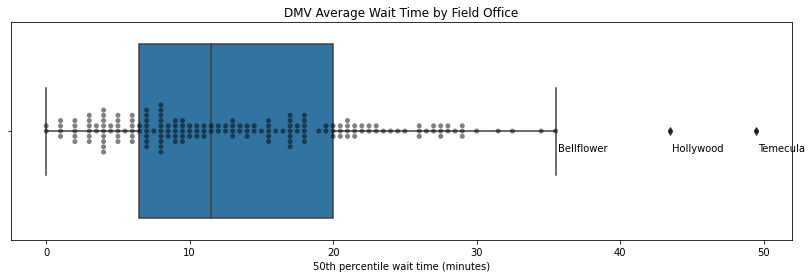

In [7]:
# Daily_wait_50
df_mean_wait_time = wait_time_descriptive_stats_df["weekday_wait_50"]
df_mean_wait_time = df_mean_wait_time.to_frame()

fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(ax=ax, x="weekday_wait_50",data=df_mean_wait_time)
ax = sns.swarmplot(x='weekday_wait_50', data=df_mean_wait_time, color="black", alpha=0.5)

plt.title("DMV Average Wait Time by Field Office")
plt.xlabel("50th percentile wait time (minutes)")

# df_mean_wait_time.head(1)
for row in df_mean_wait_time.iterrows():
    if row[1][0] > 35: #only label wait times > 25 min
        ax.annotate(row[0], xy=(row[1][0], .1), xytext=(2,2), textcoords='offset points', fontsize=10)

#### Average short wait by location

25th percentile wait in each dmv field office

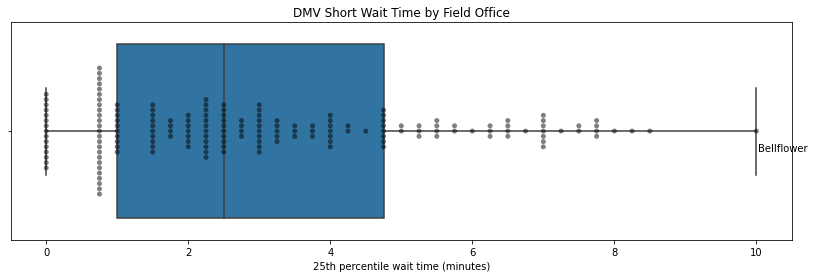

In [25]:
# Daily_wait_25
df_25_wait_time = wait_time_descriptive_stats_df["weekday_wait_25"]
df_25_wait_time = df_25_wait_time.to_frame()

fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(ax=ax, x="weekday_wait_25",data=df_25_wait_time)
ax = sns.swarmplot(x='weekday_wait_25', data=df_25_wait_time, color="black", alpha=0.5)

plt.title("DMV Short Wait Time by Field Office")
plt.xlabel("25th percentile wait time (minutes)")

# df_mean_wait_time.head(1)
for row in df_25_wait_time.iterrows():
    if row[1][0] > 9: #only label wait times > 9 min
        ax.annotate(row[0], xy=(row[1][0], .1), xytext=(2,2), textcoords='offset points', fontsize=10)

#### Average long wait by location

75th percentile wait in each dmv field office.

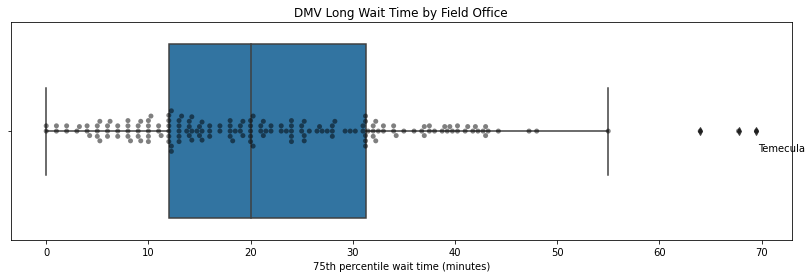

In [24]:
# Daily_wait_75
df_mean_wait_time = wait_time_descriptive_stats_df["weekday_wait_75"]
df_mean_wait_time = df_mean_wait_time.to_frame()

fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(ax=ax, x="weekday_wait_75",data=df_mean_wait_time)
ax = sns.swarmplot(x='weekday_wait_75', data=df_mean_wait_time, color="black", alpha=0.5)

plt.title("DMV Long Wait Time by Field Office")
plt.xlabel("75th percentile wait time (minutes)")

# df_mean_wait_time.head(1)
for row in df_mean_wait_time.iterrows():
    if row[1][0] > 68: #only label wait times > 68 min -- labels ovelap is I try to show too many. need to figure out workaround
        ax.annotate(row[0], xy=(row[1][0], .1), xytext=(2,2), textcoords='offset points', fontsize=10)

#### Average wait times by weekday hour

In [15]:
wait_time_descriptive_stats_df.columns

Index(['M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16',
       'M17', 'M18', 'TU7', 'TU8', 'TU9', 'TU10', 'TU11', 'TU12', 'TU13',
       'TU14', 'TU15', 'TU16', 'TU17', 'TU18', 'W7', 'W8', 'W9', 'W10', 'W11',
       'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'TH7', 'TH8', 'TH9',
       'TH10', 'TH11', 'TH12', 'TH13', 'TH14', 'TH15', 'TH16', 'TH17', 'TH18',
       'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
       'F17', 'F18', 'SA7', 'SA8', 'SA9', 'SA10', 'SA11', 'SA12', 'SA13',
       'SA14', 'SA15', 'SA16', 'SA17', 'SA18', 'daily_wait_std',
       'daily_wait_25', 'daily_wait_50', 'daily_wait_75', 'weekday_wait_std',
       'weekday_wait_25', 'weekday_wait_50', 'weekday_wait_75', 'mon_avg',
       'tues_avg', 'wed_avg', 'thurs_avg', 'fri_avg', 'sat_avg',
       '7_weekday_hour_avg_wait', '8_weekday_hour_avg_wait',
       '9_weekday_hour_avg_wait', '10_weekday_hour_avg_wait',
       '11_weekday_hour_avg_wait', '12_weekday_hour_avg_wait',


In [16]:
weekday_hour_cols = [
    '7_weekday_hour_avg_wait', '8_weekday_hour_avg_wait',
    '9_weekday_hour_avg_wait', '10_weekday_hour_avg_wait',
    '11_weekday_hour_avg_wait', '12_weekday_hour_avg_wait',
    '13_weekday_hour_avg_wait', '14_weekday_hour_avg_wait',
    '15_weekday_hour_avg_wait', '16_weekday_hour_avg_wait',
    '17_weekday_hour_avg_wait', '18_weekday_hour_avg_wait'
]

Text(0.5, 1.0, 'DMV Average Wait Time by Hour by Field Office')

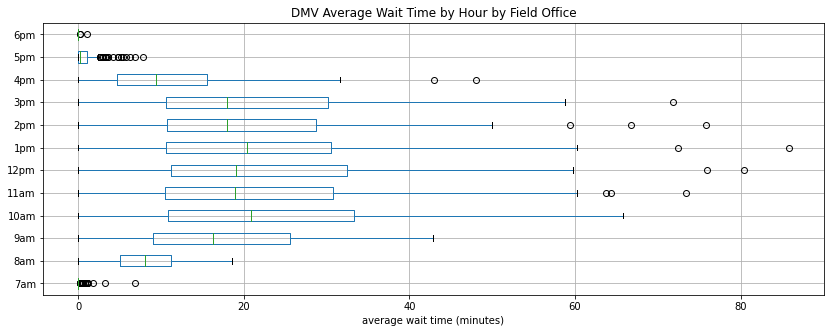

In [17]:
# rename hours columns for visualization
weekday_hours_wait_time_df = wait_time_descriptive_stats_df[weekday_hour_cols]
weekday_hours_wait_time_df = weekday_hours_wait_time_df.rename(columns=
               {'7_weekday_hour_avg_wait': '7am', '8_weekday_hour_avg_wait': '8am',
                '9_weekday_hour_avg_wait': '9am', '10_weekday_hour_avg_wait': '10am',
                '11_weekday_hour_avg_wait': '11am', '12_weekday_hour_avg_wait': '12pm',
                '13_weekday_hour_avg_wait': '1pm', '14_weekday_hour_avg_wait': '2pm',
                '15_weekday_hour_avg_wait': '3pm', '16_weekday_hour_avg_wait': '4pm',
                '17_weekday_hour_avg_wait': '5pm', '18_weekday_hour_avg_wait': '6pm'
                        })
hours_box_plot = weekday_hours_wait_time_df.boxplot(vert=False, figsize=(14,5))
hours_box_plot.set_xlabel("average wait time (minutes)")
hours_box_plot.set_title("DMV Average Wait Time by Hour by Field Office")

#### Average wait time by day of the week by field office


In [18]:
wait_time_descriptive_stats_df.columns

Index(['M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16',
       'M17', 'M18', 'TU7', 'TU8', 'TU9', 'TU10', 'TU11', 'TU12', 'TU13',
       'TU14', 'TU15', 'TU16', 'TU17', 'TU18', 'W7', 'W8', 'W9', 'W10', 'W11',
       'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'TH7', 'TH8', 'TH9',
       'TH10', 'TH11', 'TH12', 'TH13', 'TH14', 'TH15', 'TH16', 'TH17', 'TH18',
       'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
       'F17', 'F18', 'SA7', 'SA8', 'SA9', 'SA10', 'SA11', 'SA12', 'SA13',
       'SA14', 'SA15', 'SA16', 'SA17', 'SA18', 'daily_wait_std',
       'daily_wait_25', 'daily_wait_50', 'daily_wait_75', 'weekday_wait_std',
       'weekday_wait_25', 'weekday_wait_50', 'weekday_wait_75', 'mon_avg',
       'tues_avg', 'wed_avg', 'thurs_avg', 'fri_avg', 'sat_avg',
       '7_weekday_hour_avg_wait', '8_weekday_hour_avg_wait',
       '9_weekday_hour_avg_wait', '10_weekday_hour_avg_wait',
       '11_weekday_hour_avg_wait', '12_weekday_hour_avg_wait',


In [19]:
weekday_cols = ['mon_avg', 'tues_avg', 'wed_avg', 'thurs_avg', 'fri_avg', 'sat_avg',]

Text(0.5, 1.0, 'DMV Average Wait Time by Day by Field Office')

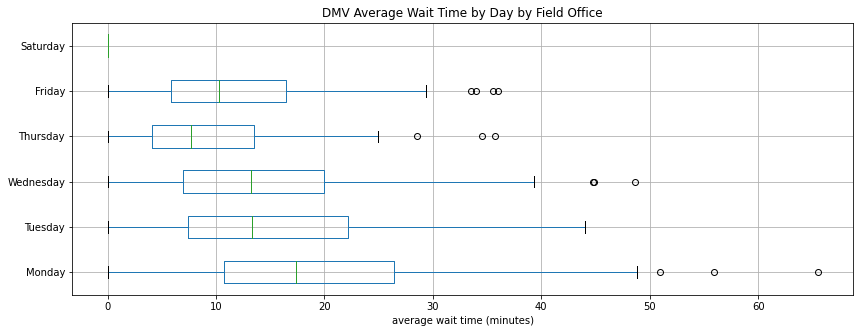

In [20]:
# rename hours columns for visualization
weekday_daily_avg_wait_time_df = wait_time_descriptive_stats_df[weekday_cols]
weekday_daily_avg_wait_time_df = weekday_daily_avg_wait_time_df.rename(columns=
               {'mon_avg': 'Monday', 'tues_avg': 'Tuesday',
               'wed_avg': 'Wednesday', 'thurs_avg': 'Thursday',
               'fri_avg': 'Friday', 'sat_avg': 'Saturday'})
hours_box_plot = weekday_daily_avg_wait_time_df.boxplot(vert=False, figsize=(14,5))
hours_box_plot.set_xlabel("average wait time (minutes)")
hours_box_plot.set_title("DMV Average Wait Time by Day by Field Office")

### Normalize Data with Location

nice. the y-axis for time and day need to be ordered

https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range

we can also normalize within location by subtracting the mean and dividing by max - min and plotting that as that does relative waits within location

formula = (x - mean(x))/(max(x) - min(x))

In [ ]:
normalized_df=(df-df.min())/(df.max()-df.min())


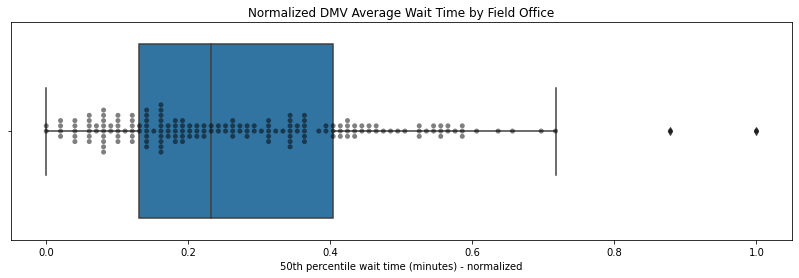

In [21]:
# Normalized daily_wait_50
df_mean_wait_time = wait_time_descriptive_stats_df["weekday_wait_50"]

normalized_df_wait_time = (df_mean_wait_time-df_mean_wait_time.min())/(df_mean_wait_time.max()-df_mean_wait_time.min())
normalized_df_wait_time = normalized_df_wait_time.to_frame()

fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(ax=ax, x="weekday_wait_50",data=normalized_df_wait_time)
ax = sns.swarmplot(x='weekday_wait_50', data=normalized_df_wait_time, color="black", alpha=0.5)

plt.title("Normalized DMV Average Wait Time by Field Office")
plt.xlabel("50th percentile wait time (minutes) - normalized")

# df_mean_wait_time.head(1)
for row in normalized_df_wait_time.iterrows():
    if row[1][0] > 35: #only label wait times > 25 min
        ax.annotate(row[0], xy=(row[1][0], .1), xytext=(2,2), textcoords='offset points', fontsize=10)

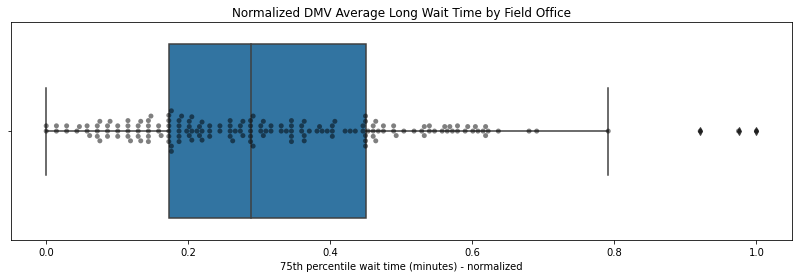

In [26]:
# Normalized daily_wait_75
df_mean_wait_time = wait_time_descriptive_stats_df["weekday_wait_75"]

normalized_df_wait_time = (df_mean_wait_time-df_mean_wait_time.min())/(df_mean_wait_time.max()-df_mean_wait_time.min())
normalized_df_wait_time = normalized_df_wait_time.to_frame()

fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(ax=ax, x="weekday_wait_75",data=normalized_df_wait_time)
ax = sns.swarmplot(x='weekday_wait_75', data=normalized_df_wait_time, color="black", alpha=0.5)

plt.title("Normalized DMV Average Long Wait Time by Field Office")
plt.xlabel("75th percentile wait time (minutes) - normalized")

# df_mean_wait_time.head(1)
for row in normalized_df_wait_time.iterrows():
    if row[1][0] > 35: #only label wait times > 25 min
        ax.annotate(row[0], xy=(row[1][0], .1), xytext=(2,2), textcoords='offset points', fontsize=10)

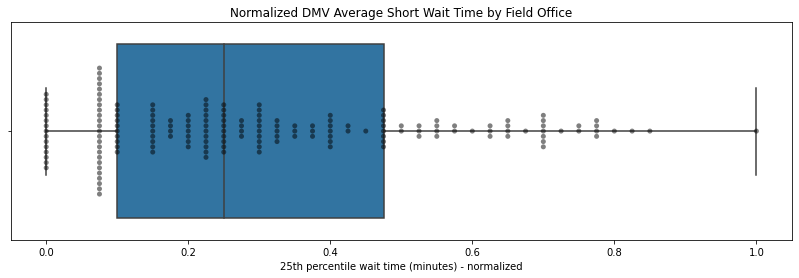

In [27]:
# Normalized daily_wait_25
df_mean_wait_time = wait_time_descriptive_stats_df["weekday_wait_25"]

normalized_df_wait_time = (df_mean_wait_time-df_mean_wait_time.min())/(df_mean_wait_time.max()-df_mean_wait_time.min())
normalized_df_wait_time = normalized_df_wait_time.to_frame()

fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(ax=ax, x="weekday_wait_25",data=normalized_df_wait_time)
ax = sns.swarmplot(x='weekday_wait_25', data=normalized_df_wait_time, color="black", alpha=0.5)

plt.title("Normalized DMV Average Short Wait Time by Field Office")
plt.xlabel("25th percentile wait time (minutes) - normalized")

# df_mean_wait_time.head(1)
for row in normalized_df_wait_time.iterrows():
    if row[1][0] > 35: #only label wait times > 25 min
        ax.annotate(row[0], xy=(row[1][0], .1), xytext=(2,2), textcoords='offset points', fontsize=10)

Text(0.5, 1.0, 'Normalized DMV Average Wait Time by Hour by Field Office')

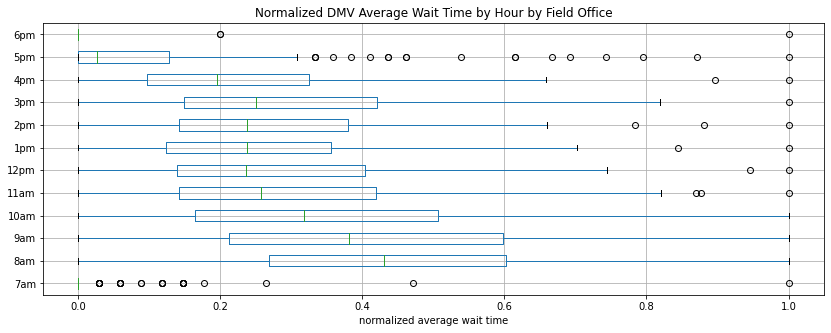

In [29]:
# Normalized Wait Time by Office
weekday_hours_wait_time_df = wait_time_descriptive_stats_df[weekday_hour_cols]
weekday_hours_wait_time_df = weekday_hours_wait_time_df.rename(columns=
               {'7_weekday_hour_avg_wait': '7am', '8_weekday_hour_avg_wait': '8am',
                '9_weekday_hour_avg_wait': '9am', '10_weekday_hour_avg_wait': '10am',
                '11_weekday_hour_avg_wait': '11am', '12_weekday_hour_avg_wait': '12pm',
                '13_weekday_hour_avg_wait': '1pm', '14_weekday_hour_avg_wait': '2pm',
                '15_weekday_hour_avg_wait': '3pm', '16_weekday_hour_avg_wait': '4pm',
                '17_weekday_hour_avg_wait': '5pm', '18_weekday_hour_avg_wait': '6pm'
                        })

normalized_weekday_hours_wait_time_df = (weekday_hours_wait_time_df - weekday_hours_wait_time_df.min())/ (weekday_hours_wait_time_df.max() - weekday_hours_wait_time_df.min())

hours_box_plot = normalized_weekday_hours_wait_time_df.boxplot(vert=False, figsize=(14,5))
hours_box_plot.set_xlabel("normalized average wait time")
hours_box_plot.set_title("Normalized DMV Average Wait Time by Hour by Field Office")

Text(0.5, 1.0, 'Normalized DMV Average Wait Time by Day by Field Office')

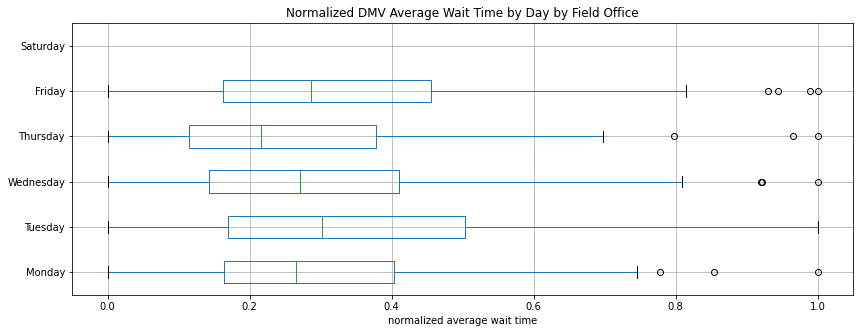

In [31]:
# normalized wait time by office
weekday_daily_avg_wait_time_df = wait_time_descriptive_stats_df[weekday_cols]
weekday_daily_avg_wait_time_df = weekday_daily_avg_wait_time_df.rename(columns=
               {'mon_avg': 'Monday', 'tues_avg': 'Tuesday',
               'wed_avg': 'Wednesday', 'thurs_avg': 'Thursday',
               'fri_avg': 'Friday', 'sat_avg': 'Saturday'})


normalized_weekday_daily_avg_wait_time_df = (weekday_daily_avg_wait_time_df-weekday_daily_avg_wait_time_df.min())/(weekday_daily_avg_wait_time_df.max()-weekday_daily_avg_wait_time_df.min())

hours_box_plot = normalized_weekday_daily_avg_wait_time_df.boxplot(vert=False, figsize=(14,5))
hours_box_plot.set_xlabel("normalized average wait time")
hours_box_plot.set_title("Normalized DMV Average Wait Time by Day by Field Office")

### Sociodem Data